# Image Embeddings, Clustering, and Similarity Search

This notebook demonstrates:

1. Loading and exploring the Fashion MNIST dataset
2. Extracting image embeddings using a pre-trained DINO Vision Transformer
3. Visualizing embeddings in 2D using UMAP
4. Performing nearest-neighbor search on embeddings to retrieve similar images

The goal is to understand how deep models represent images in feature space and how this enables clustering and similarity-based retrieval.

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from umap import UMAP
from datasets import load_dataset
from torchvision import transforms
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from transformers import AutoImageProcessor, AutoModel


# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Dataset: Fashion MNIST

In this demo, we use the `Fashion MNIST` dataset, a modern alternative to the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset traditionally used for handwriting recognition. 

Fashion MNIST contains 70,000 grayscale images, each 28x28 pixels, distributed across 10 different clothing categories. These images are small, detailed, and varied enough to challenge our model while being simple enough for straightforward processing and quick training times.

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

### 1.1 Dataset Structure

The dataset is split into two parts:

- **Training Set:** This includes `train_images` and `train_labels`. These are the arrays that our model will learn from. The model sees these images and their corresponding labels, adjusting its weights and biases to reduce classification error.

- **Test Set:** This comprises `test_images` and `test_labels`. These are used to evaluate how well our model performs on data it has never seen before. This is crucial for understanding the model's generalization capability.

### 1.2 Understanding the Data

Each image in the dataset is a 28x28 NumPy array. The pixel values range from 0 to 255, with 0 being black, 255 being white, and the various shades of gray in between. The labels are integers from 0 to 9, each representing a specific category of clothing.

**Class Names:**

The dataset doesn't include the names of the clothing classes, so we will manually define them for clarity when visualizing our results. Here's the mapping:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>


We will use a subset of the training set to build embeddings and visualize structure.

## 2. Loading the dataset

Let's load the Fashion MNIST dataset directly from PyTorch:

In [2]:
# class names for Fashion MNIST
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# define transformation: convert to tensor and normalize
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


# load dataset and apply transformation
train_data = load_dataset("fashion_mnist", split="train")
print("Training set has {} instances".format(len(train_data)))

# convert dataset to tensors and store in memory for fast access
train_images = []
train_labels = []
for example in train_data:
    img = transform(example["image"])
    label = example["label"]
    train_images.append(img)
    train_labels.append(label)

train_images = torch.stack(train_images)  # shape: (60000, 1, 28, 28)
train_labels = torch.tensor(train_labels)  # shape: (60000,)

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

Training set has 60000 instances
Train images shape: torch.Size([60000, 1, 28, 28])
Train labels shape: torch.Size([60000])


In [3]:
# analyze class distribution
from collections import Counter

train_list = [item["label"] for item in train_data]
label_counts = Counter(train_list)

print("Class distribution:")
for i in range(10):
    print(
        f"{class_names[i]:15s}: {label_counts[i]:5d} images ({label_counts[i] / len(train_data) * 100:.1f}%)"
    )

Class distribution:
T-shirt/top    :  6000 images (10.0%)
Trouser        :  6000 images (10.0%)
Pullover       :  6000 images (10.0%)
Dress          :  6000 images (10.0%)
Coat           :  6000 images (10.0%)
Sandal         :  6000 images (10.0%)
Shirt          :  6000 images (10.0%)
Sneaker        :  6000 images (10.0%)
Bag            :  6000 images (10.0%)
Ankle boot     :  6000 images (10.0%)


## 3. Understanding Pixel Values

- Each image in the Fashion MNIST dataset is represented in grayscale with pixel values ranging from 0 to 255.

- We applied Scaling and Normalization methods so that each pixel value is centered around 0 and falls within the range [-1, 1].

- This normalization is often used in deep learning models as it centers the data around 0, which can lead to faster convergence during training. It can also help mitigate issues caused by different lighting and contrast in images.

- The value `-1` represents black, `1` represents white, and the values in between represent various shades of gray.

Let's inspect the first image in the training set displaying these pixel values:

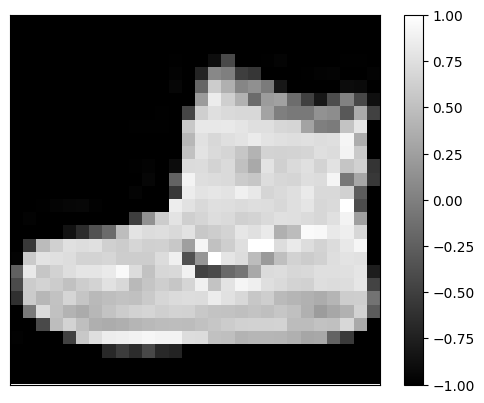

In [4]:
# Plotting firt image
plt.figure()
plt.imshow(train_images[0][0], cmap="gray")  # first image in the dataset
plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

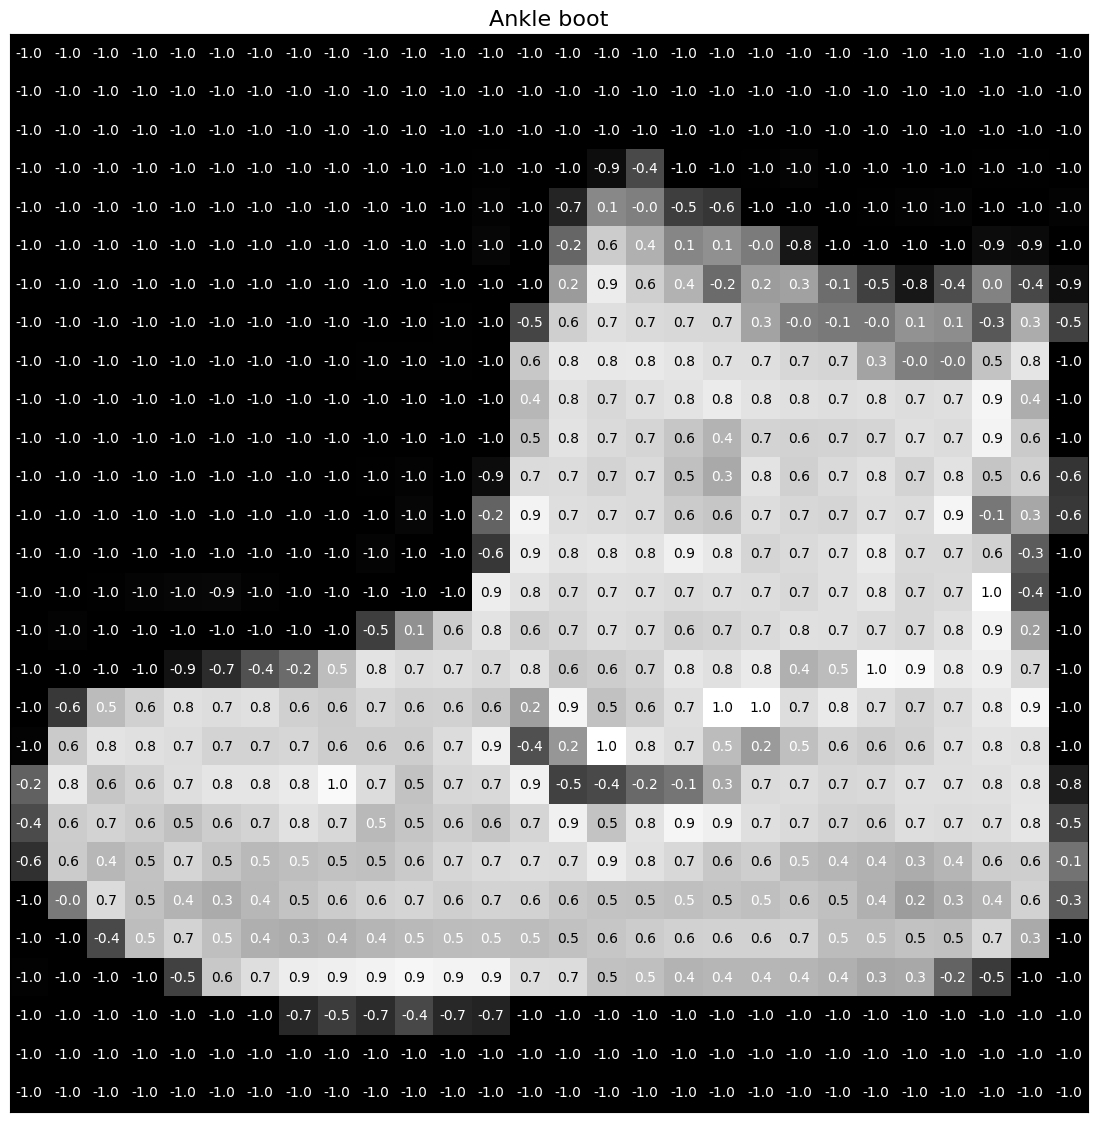

In [5]:
def get_text_color(value: float) -> str:
    """Returns 'white' for dark pixels and 'black' for light pixels."""
    return "white" if value < 0.5 else "black"


image_numpy = train_images[0][0].squeeze().numpy()
label = train_labels[0]

# Plotting the image
plt.figure(figsize=(14, 14))
plt.imshow(image_numpy, cmap="gray")
plt.title(
    class_names[label],
    fontsize=16,
)
plt.grid(False)
plt.xticks([])
plt.yticks([])

# Overlaying the pixel values
for i in range(image_numpy.shape[0]):
    for j in range(image_numpy.shape[1]):
        plt.text(
            j,
            i,
            "{:.1f}".format(image_numpy[i, j]),
            ha="center",
            va="center",
            color=get_text_color(image_numpy[i, j]),
        )
plt.show()

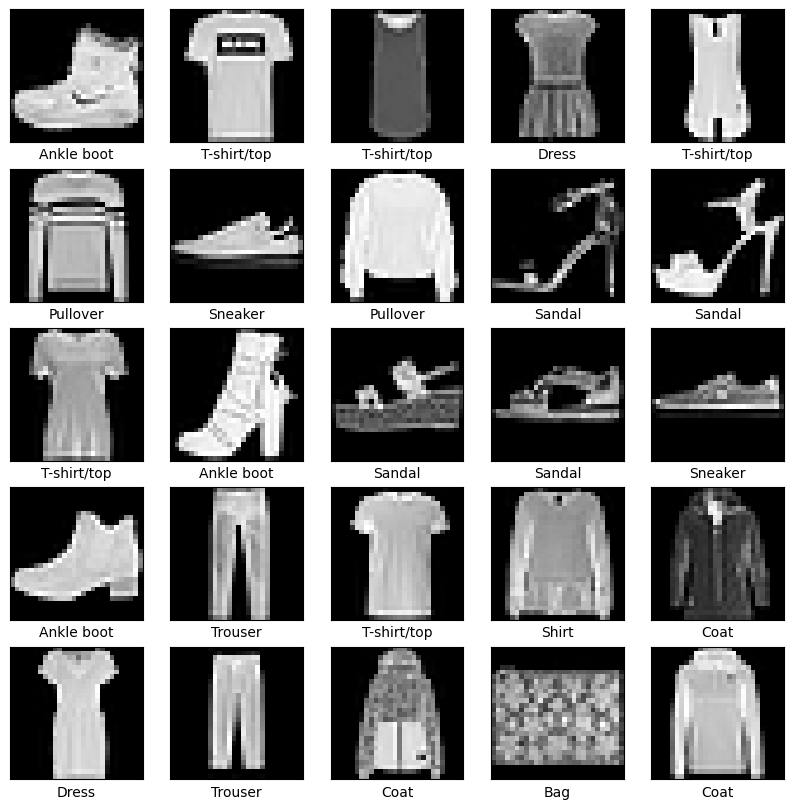

In [6]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][0], cmap="gray")
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 5. Image Embeddings

Deep learning models do not compare images at the level of raw pixels. Instead, they convert images into **embeddings** — numerical feature vectors that capture the visual characteristics of the image.

### What are Image Embeddings?

An embedding is a vector representation where:

- Images that are visually similar have **similar embeddings**
- Images that are visually different have **distant embeddings**

This allows us to measure similarity between images using vector distances (e.g., cosine similarity).

### Why Use a Pretrained Model?

Training a feature extractor from scratch requires large datasets and compute. Instead, we use a **pretrained vision transformer**, which has learned general visual patterns such as edges, textures, shapes, and object parts.

### [DINOv2: A Self-supervised Vistion Transformer Model](https://dinov2.metademolab.com/)

We will use **DINOv2**, a self-supervised vision transformer model. It learns useful visual representations **without labels**, making it a strong general-purpose feature extractor.

- Input: an image
- Output: a fixed-length embedding (e.g., a 768-dimensional vector)
- Benefit: embeddings can be used for visualization, clustering, and similarity search

We now load DINOv2 and extract embeddings for our Fashion MNIST images.


In [7]:
# choose model
model_name = "facebook/dinov2-base"

# load processor and model
processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = AutoModel.from_pretrained(model_name).eval().to(device)

print("Model loaded.")
print("Embedding dimension:", model.config.hidden_size)

Model loaded.
Embedding dimension: 768


## 6. Extracting Image Embeddings

Fashion MNIST images are 28×28 grayscale images. DINOv2 expects RGB images at a higher resolution.  
We convert each image to RGB and allow the model’s image processor to handle resizing and normalization.

To avoid memory issues, embeddings are extracted in batches.  
Each image is mapped to a single embedding vector (here, 768-dimensional for DINOv2 Base).


In [8]:
def extract_embeddings(model, images: torch.Tensor, batch_size: int = 64) -> np.ndarray:
    """
    Extract embeddings from a batch of images using DINOv2.

    Args:
        model: Pretrained DINOv2 model
        images: Tensor of shape (N, 1, 28, 28)
        batch_size: Number of images per batch for the model

    Returns:
        numpy array of shape (N, embedding_dim)
    """
    all_embeddings = []

    model.eval()
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i : i + batch_size]

            # convert tensor grayscale -> PIL RGB list
            pil_batch = [
                Image.fromarray((img.squeeze().numpy() * 255).astype(np.uint8)).convert(
                    "RGB"
                )
                for img in batch
            ]

            # preprocess for model
            inputs = processor(images=pil_batch, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # forward pass
            outputs = model(**inputs)

            # extract CLS token representation
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_embeddings)

    return np.vstack(all_embeddings)

In [9]:
# randomly sample a subset of images
num_samples = 5000
indices = np.random.choice(len(train_images), size=num_samples, replace=False)

# extract subset of images and labels
subset_images = train_images[indices]
subset_labels = train_labels[indices]

print("Extracting embeddings...")
embeddings = extract_embeddings(model, subset_images, batch_size=64)
print("Embeddings shape:", embeddings.shape)

Extracting embeddings...
Embeddings shape: (5000, 768)


## 7. Dimensionality Reduction with UMAP

The embeddings produced by DINOv2 are 768-dimensional vectors.  
To understand how images relate to one another, we project these embeddings into **two dimensions** for visualization.

### UMAP

We use **[UMAP (Uniform Manifold Approximation and Projection)](https://umap-learn.readthedocs.io/en/latest/)**, a method that:
- Reduces high-dimensional data to 2D
- Preserves neighborhood structure (similar items stay close)
- Works efficiently on large datasets

If the embeddings capture meaningful visual structure, images from the same clothing class should form clusters in the 2D projection.


In [10]:
# reduce 768D embeddings to 2D for visualization
umap_reducer = UMAP(
    n_components=2,
    metric="cosine",
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
)

# fit and transform
embeddings_2d = umap_reducer.fit_transform(embeddings)
print("UMAP projection shape:", embeddings_2d.shape)

/storage/home/hcoda1/9/mgustineli3/dsgt-arc/fall-2025-interest-group-projects/project/02-embeddings/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection shape: (5000, 2)


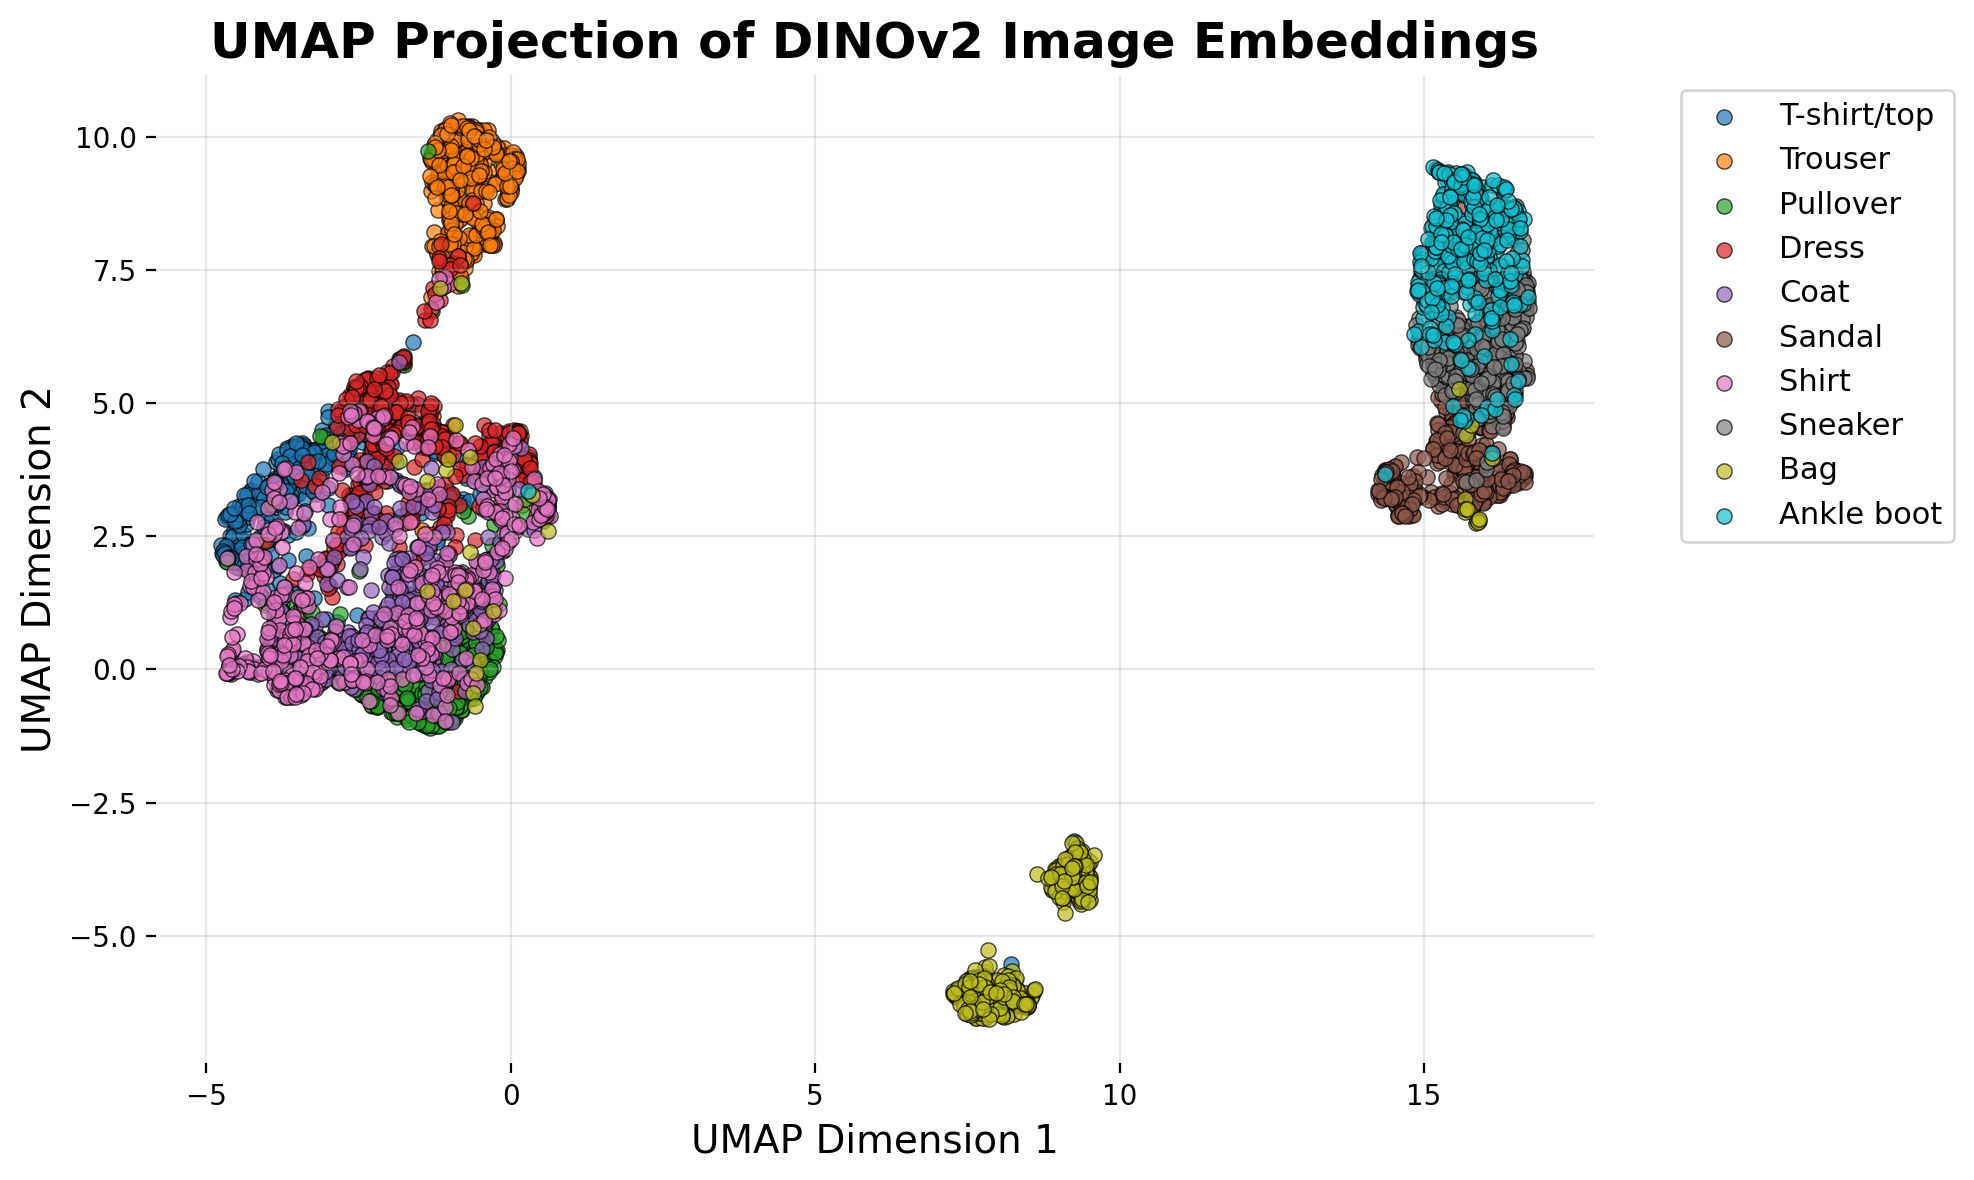

In [11]:
# create visualization of clusters
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# create a color for each class
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# overlay colored points by class
for class_id in range(10):
    mask = subset_labels == class_id
    ax.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[class_id]],
        label=class_names[class_id],
        alpha=0.7,
        s=30,
        edgecolors="black",
        linewidths=0.5,
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=11)
ax.set_title(
    "UMAP Projection of DINOv2 Image Embeddings",
    fontsize=18,
    fontweight="bold",
)
ax.set_xlabel("UMAP Dimension 1", fontsize=14)
ax.set_ylabel("UMAP Dimension 2", fontsize=14)
ax.grid(True, alpha=0.3)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

## 8. Evaluating Cluster Quality

Once the embeddings are projected to 2D, we can assess how well the points form clusters.  
We use the **Silhouette Score**, which measures how similar a sample is to its own class compared to other classes.

### Silhouette Score Interpretation

| Score Range | Interpretation |
|------------|----------------|
| 0.50 – 1.00 | Clear, well-separated clusters |
| 0.26 – 0.49 | Some clustering structure with overlap |
| 0.00 – 0.25 | Weak clustering or heavy overlap |
| < 0 | Points may be assigned to the wrong cluster |

Fashion MNIST typically falls in the **0.25–0.45** range.  
Some classes (e.g., *Sneaker*, *Bag*) are visually distinct, while others (e.g., *T-shirt/top* vs *Shirt*) look similar, leading to overlapping clusters.

The Silhouette Score provides a single numeric summary, but the visualization remains the primary way to interpret how the model organizes the data.

In [12]:
# after UMAP, check cluster quality
# Silhouette score: how well the projected points form clusters
score = silhouette_score(embeddings_2d, subset_labels, metric="euclidean")
print(f"Silhouette Score: {score:.3f}")
print("(Higher is better, range: -1 to 1)")

Silhouette Score: 0.254
(Higher is better, range: -1 to 1)


## 9. Similarity Search with Nearest Neighbors

Because each image is now represented as an embedding vector, we can measure similarity between images by comparing these vectors.

We use **K-Nearest Neighbors (KNN)** to retrieve the closest images in embedding space:

- The **query image** is compared to all others.
- We compute distances between embedding vectors.
- The top matches are returned as the most similar images.

This provides a simple way to perform:
- Image retrieval
- Recommendation based on visual similarity
- Non-parametric classification (no training required)


In [13]:
# fit nearest neighbors model on embeddings
nn_model = NearestNeighbors(n_neighbors=5, metric="cosine")
nn_model.fit(embeddings)

,n_neighbors,5
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [14]:
def show_nearest_neighbors(query_index: int, k: int = 6):
    """
    Display a query image and its nearest neighbors in embedding space.
    """
    k += 1  # include query image
    distances, indices = nn_model.kneighbors([embeddings[query_index]], n_neighbors=k)

    # set figure width proportional to k
    fig_width = max(8, k * 2)  # scales nicely for k=6, 8, 10, ...
    fig, axes = plt.subplots(1, k, figsize=(fig_width, 3), dpi=150)

    # ensure axes is iterable
    if k == 1:
        axes = [axes]

    fig.suptitle(
        "Query Image and Top-5 Most Similar Images", fontsize=14, weight="bold", y=1.05
    )

    for i, (ax, idx) in enumerate(zip(axes, indices[0])):
        img = subset_images[idx][0].cpu().numpy()
        label = class_names[subset_labels[idx]]

        ax.imshow(img, cmap="gray")

        if i == 0:
            ax.set_title(f"Query\n({label})", fontsize=10, weight="bold")
        else:
            similarity = 1 - distances[0][i]
            ax.set_title(f"{label}\nSim={similarity:.2f}", fontsize=9)

        ax.set_xticks([])
        ax.set_yticks([])

    # reserve extra vertical space for suptitle
    fig.subplots_adjust(top=1, wspace=0.2)
    plt.show()

Query image class: Dress


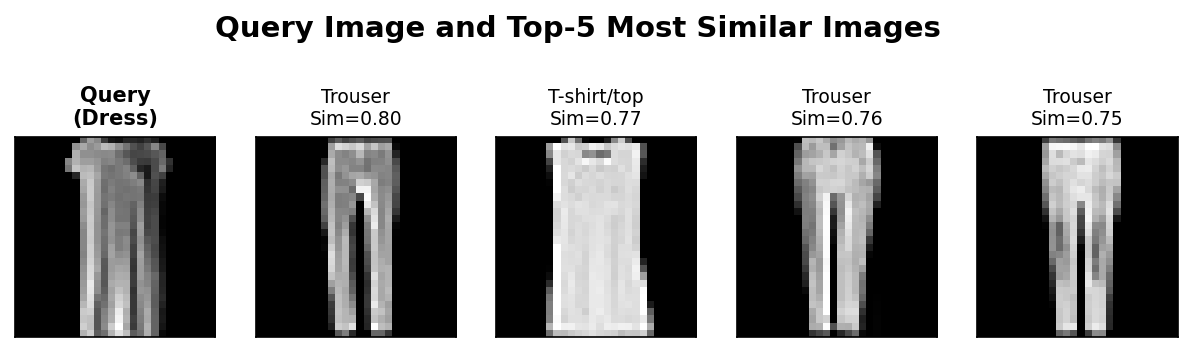

In [15]:
# choose a random test image from the subset
query = np.random.randint(0, num_samples)

print("Query image class:", class_names[subset_labels[query]])
show_nearest_neighbors(query, k=4)

In [16]:
def find_and_visualize_class(class_name, sample_labels=subset_labels, k: int = 5):
    """
    Find random image from a class and show similar images
    """
    # Get class id
    class_name = class_name.capitalize()  # ensure proper capitalization
    class_id = class_names.index(class_name)

    # Find images of this class in our sample
    class_indices = np.where(sample_labels == class_id)[0]

    if len(class_indices) == 0:
        print(f"No {class_name} found in sample!")
        return

    # Pick random image
    query_idx = random.choice(class_indices)

    print(f"Finding images similar to a {class_name}...")
    show_nearest_neighbors(query_idx, k=k)

Finding images similar to a Sneaker...


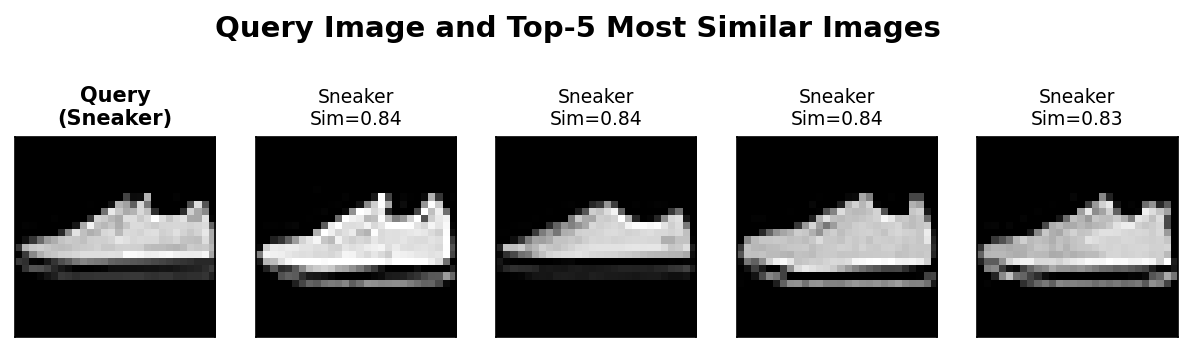

In [17]:
# try it out! change the class name below
find_and_visualize_class("sneaker", k=4)

## 10. Key Takeaways

### Embeddings
- Deep models represent images as numerical vectors (embeddings).
- Images that are visually or semantically similar have embeddings that are close in vector space.
- These representations capture structure beyond raw pixel similarity.

### Clustering in Embedding Space
- Without any additional training, similar items naturally form clusters.
- This occurs because the pretrained model has learned general visual features from large-scale image data.
- Clothing categories in Fashion MNIST occupy distinct regions in embedding space, with some expected overlap between visually similar classes.

### Dimensionality Reduction
- UMAP provides a way to project high-dimensional embeddings into a 2D space for visualization.
- The 2D visualization reflects underlying structure, though some information is lost in the projection.
- Cluster separation can be evaluated quantitatively with the Silhouette Score.

### Similarity Search with Nearest Neighbors
- Nearest neighbor search allows us to retrieve images that are similar to a query image.
- This demonstrates how embeddings can support tasks such as classification, recommendation, and search without training a model.

### Possible Extensions
1. Try different variants of DINO (e.g., ViT-S, ViT-B, ViT-L) and compare embedding quality.
2. Experiment with UMAP parameters (e.g., `n_neighbors`, `min_dist`) to adjust cluster compactness.
3. Compare UMAP with PCA or t-SNE for dimensionality reduction.
4. Implement K-Nearest Neighbor classification directly on embeddings.
5. Apply the pipeline to a different dataset (e.g., CIFAR-10) or your own images.

This pipeline demonstrates how pretrained vision models enable visualization, clustering, and similarity-based retrieval directly from image embeddings.
